# 1. 3D audio

In [28]:
import pydub
import numpy as np
import sounddevice as sd
import cmath
from matplotlib import pyplot as plt
from scipy.io.wavfile import read, write
from scipy.io import wavfile
from math import e

class Music: # static class for music I/O standard
    
    @staticmethod
    def plotter(x=None, y=None, title="", xlabel="", ylabel="", figsize=(20, 12), subplt=(1, 1, 1)):
        """
            East plotter
        """
        if x is None:
            x = np.arange(y.shape[0])
        plt.figure(figsize=figsize)
        plt.subplot(subplt)
        plt.plot(x, y)
        
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()
        return
    
    @staticmethod
    def frequencies(x, fs):
        """
            Audio vector to frequencies with FFT ratio
        """
        Fd = np.fft.fft(x)
        Fx = np.linspace(0, 1, max(x.shape))*fs
        return Fd, Fx
    
    @staticmethod
    def read_mp3(filename, normalized=False):
        """
            MP3 to numpy array
        """
        a = pydub.AudioSegment.from_mp3(filename)
        y = np.array(a.get_array_of_samples())
        if a.channels == 2:
            y = y.reshape((-1, 2))
        if normalized:
            return a.frame_rate, np.float32(y) / 2**15
        else:
            return a.frame_rate, y
    
    @staticmethod
    def write_mp3(filename, Fs, x, normalized=False):
        """ 
            numpy array to MP3 
        """
        channels = 2 if (x.ndim == 2 and x.shape[1] == 2) else 1
        if normalized:  
            y = np.int16(x * 2 ** 15)
        else:
            y = np.int16(x)
        song = pydub.AudioSegment(y.tobytes(), frame_rate=Fs, sample_width=2, channels=channels)
        song.export(filename, format="mp3", bitrate="320k")
        return
    

# plotter function
def freqplot(y, fs, N, t1="The signal", t2="Frequency"):

    x = np.linspace(0, y.shape[0]/fs, y.shape[0]) # Zero to 2*pi, one period
    f = np.fft.fft(y)
    p = np.linspace(0, fs, y.shape[0])

    plt.figure(figsize=(30, 10))
    
    plt.subplot(2, 1, 1)
    plt.plot(x, y)
    plt.grid(True)
    plt.xlabel("Time")
    plt.title(t1)
    
    plt.subplot(2, 1, 2)
    plt.plot(p[:N], np.abs(f[:N]))
    plt.grid(True)
    plt.xlabel("Frequency")
    plt.title(t2)
    plt.show()
    


The part below is to record an audio first but you can ignore this part you already have a mono-audio sound.

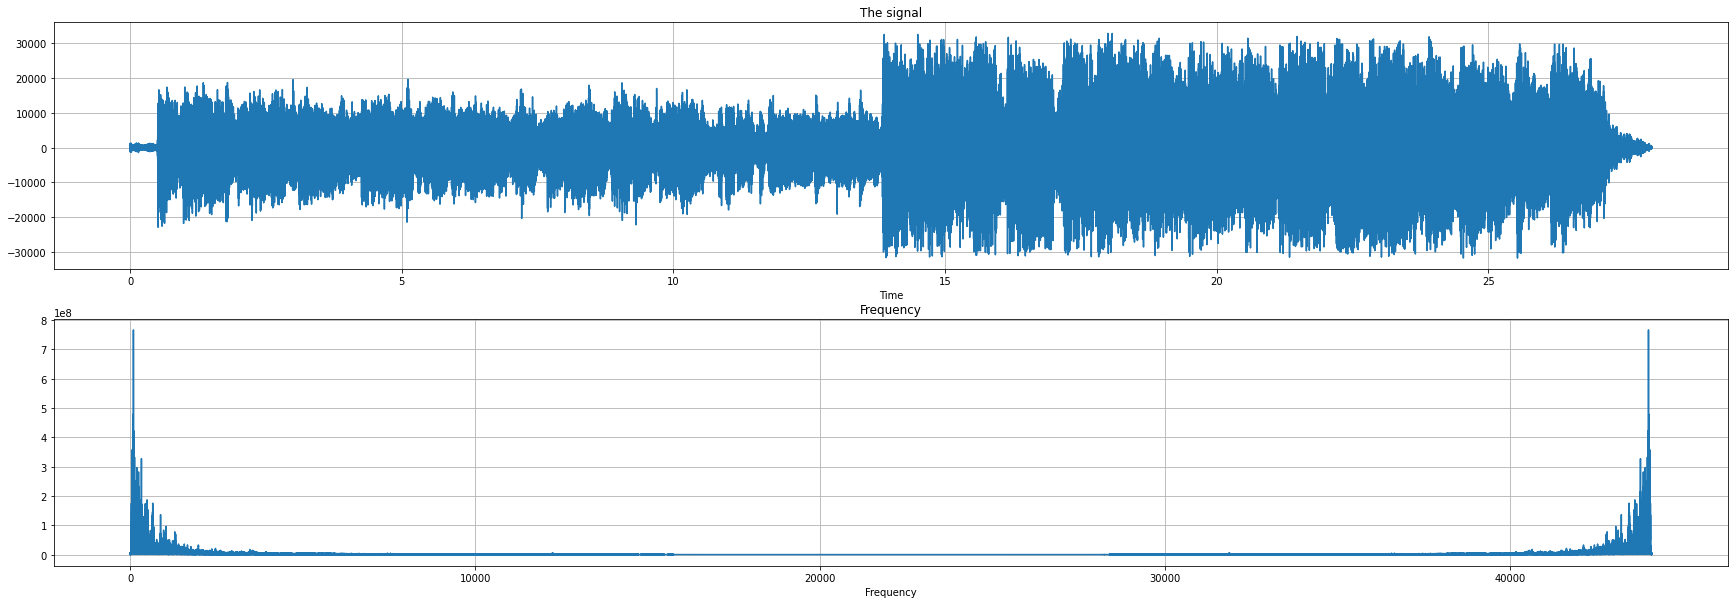

array([[211, 307],
       [ 94, 213],
       [-25, 101],
       ...,
       [476, -19],
       [532, -47],
       [650, -82]], dtype=int16)

In [116]:
fs, data = Music.read_mp3('musics/arcade.mp3')
data_selected = data[int(39.5/134 * data.shape[0]):int(60/134 * data.shape[0])]
freqplot(data_selected[:,1],fs,data_selected.shape[0])
Music.write_mp3('musics/3D_before.mp3', fs, data_selected[:,1])
data_selected

My audio before becoming 3D is saved as 3D_before.mp3

## The 3D audio creator function

In [222]:
def create_3d_audio(p, filename, output_filename):
    ## Reading the audio
    fs, data = Music.read_mp3(filename)
    channel0 = data * ((100-p)/100)
    channel1 = data * (p/100)
    output = np.zeros((data.shape[0], 2))
    output[:,0] = channel0
    output[:,1] = channel1
    output = output.astype(np.int16)
    #sd.play(output, fs)
    #sd.wait()
    Music.write_mp3(output_filename, fs, output)
    return  fs, data, output

In [223]:
fs, data, output = create_3d_audio(20, 'musics/3D_before.mp3', 'musics/3D_after.mp3')

Plotting the output of each Ear

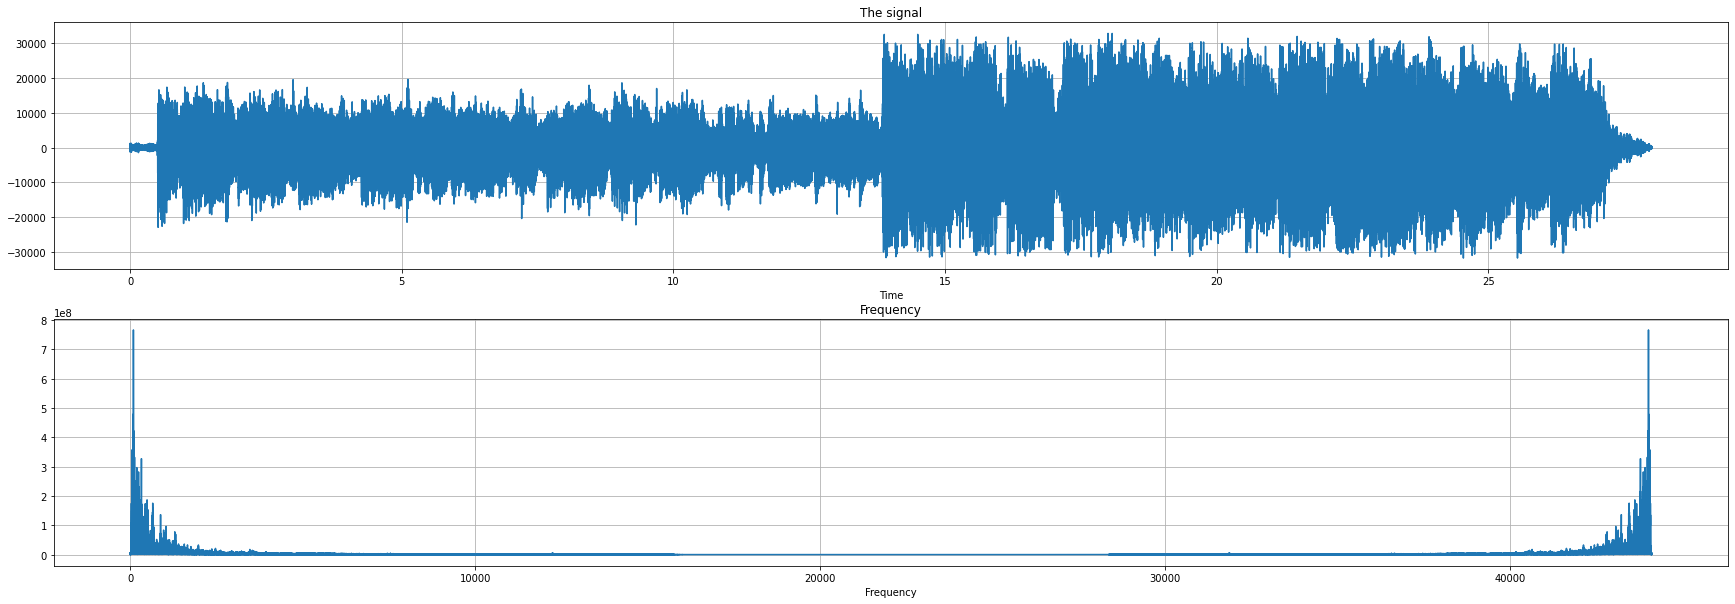

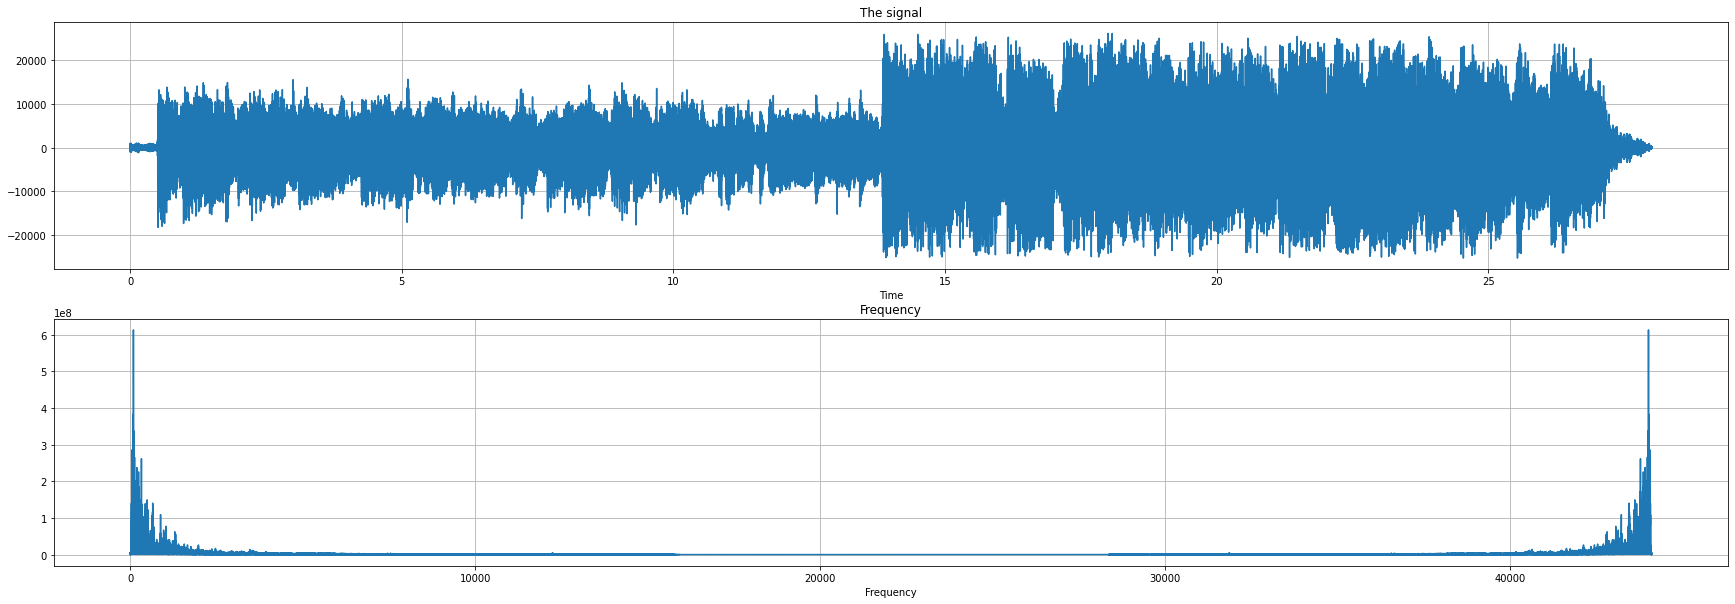

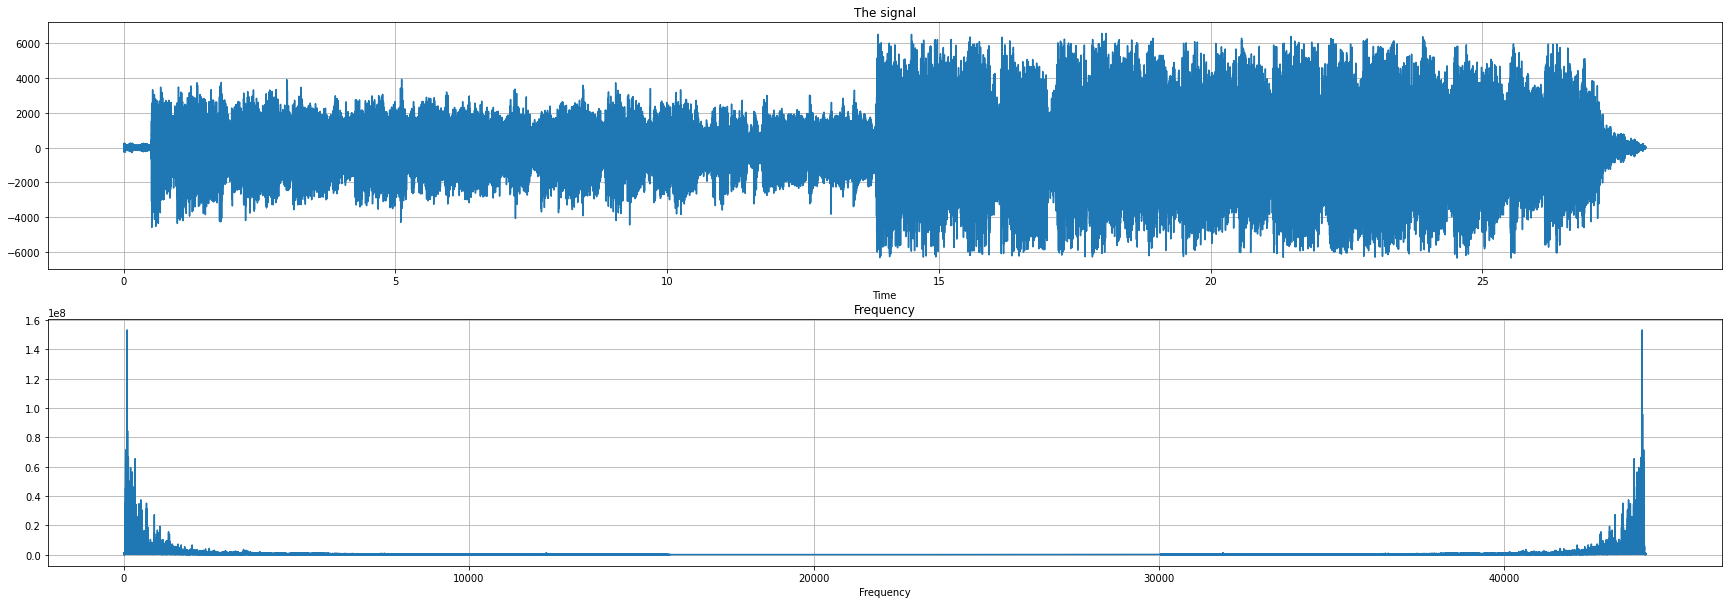

In [224]:
# input
freqplot(data, fs, output.shape[0])

# Left Ear
freqplot(output[:,0], fs, output.shape[0])

# Right Ear
freqplot(output[:,1], fs, output.shape[0])

# 2. Moving 3D audio

In [225]:
def create_circular_3d(period, filename, output_filename):
    ## Reading the audio
    fs, data = Music.read_mp3(filename)
    output = np.zeros((data.shape[0], 2))
    t = np.linspace(0, data.shape[0]/fs, data.shape[0])
    channel0 = data * np.sin(np.pi * t / period)
    channel1 = data * np.cos(np.pi * t / period)
    
    ## assembling
    output[:,0] = channel0
    output[:,1] = channel1
    output = output.astype(np.int16)
    Music.write_mp3(output_filename, fs, output)
    return fs, data, output

In [226]:
fs, data, output = create_circular_3d(5, 'musics/3D_before.mp3', 'musics/3D_moving.mp3')

# 3. Meaningful 3D audio

For this part, i just used a recorded voice from a conversation in internet where to people are talking in it.

In 0 < t < 3.8s the first person is talking and in 3.8s < t < 8.6s the second person is talking 

In [233]:
def create_3d_with_meaning(filename, output_filename):
    ## Reading the audio
    fs, data = Music.read_mp3(filename)
    output = np.zeros((data.shape[0], 2))
    weight0 = np.zeros(data.shape[0])
    weight1 = np.zeros(data.shape[0])
    t = np.linspace(0, data.shape[0] / fs, data.shape[0])
    first_change = 4.3
    second_change = 8
    third_change = 11.3
    for i in range(data.shape[0]):
        if(t[i] < first_change or second_change<t[i]<third_change):
            ## the first person is standing left
            weight0[i] = 0.8
            weight1[i] = 0.2
        else:
            ## the second person is standing right
            weight0[i] = 0.3
            weight1[i] = 0.7
    channel0 = data * weight0
    channel1 = data * weight1
    ## assembling
    output[:,0] = channel0
    output[:,1] = channel1
    output = output.astype(np.int16)
    
    #sd.play(output, fs)
    Music.write_mp3(output_filename, fs, output)
    return

In [234]:
create_3d_with_meaning('musics/sound_input.mp3', 'musics/3D_sound.mp3')